In [1]:
import sys
import os
from tqdm import tqdm
# from src.models.setup_model import setup_sam2, load_sam2

# Aggiunge il percorso del progetto al PYTHONPATH
current_dir = os.path.abspath(os.getcwd())
project_home_dir = os.path.abspath(os.path.join(current_dir, os.pardir))

sys.path.append(project_home_dir)

# # Carica il modello SAM2
# setup_sam2(project_home_dir)
# predictor = load_sam2(project_home_dir)

In [ ]:
import src.data.make_dataset as make_dataset
import src.data.image_info as image_info

slice_dict = make_dataset.load_image_slices(os.path.join(project_home_dir, r"data\raw"))
masks_path_list = {
    'BZ2': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ2_preprocessed_collagen_tissue_mask.png",
    'BZ3': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ3_preprocessed_collagen_tissue_mask.png",
    'BZ5': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ5_preprocessed_collagen_tissue_mask.png",
    'BZ6': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ6_preprocessed_collagen_tissue_mask.png",
    'RE1': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_RE1_preprocessed_collagen_tissue_mask.png",
    'RE2': r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_RE2_preprocessed_collagen_tissue_mask.png",
}


for slice_id in tqdm(slice_dict):
    mask_path = masks_path_list[slice_id]
    imageInfo = image_info.ImageSlice(slice_id)
    imageInfo.load_images(slice_dict[slice_id]['wga'], slice_dict[slice_id]['collagen'], slice_dict[slice_id]['autofluorescence'])
    imageInfo.analyse_image2(mask_path)
    imageInfo.save_results()

In [2]:
from src.models.segmentation import extract_features, perform_clustering
import cv2
def superpixel_clustering_segmentation(gray,  segments, n_clusters=2):
    """
    Funzione principale per la segmentazione con superpixel e clustering KMeans.

    Args:
        image_path: Percorso dell'immagine in scala di grigi
        mask_path: Percorso della maschera binaria
        segments: Superpixel in cui è stata suddivisa l'immagine
        n_clusters: Numero di cluster

    Returns:
      
    """
    if len(gray.shape) == 3:
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    else:
        gray = gray


    features = extract_features(gray, segments)
    masks = perform_clustering(features, segments, n_clusters)
    
    return masks

In [3]:
import cv2
import numpy as np
from skimage.segmentation import slic
from src.data.pre_process_image import enhance_image
from src.data.pre_process_image import load_tif_image, resize_image
from src.data.pre_process_image import generate_superpixels
import src.models.segmentation as seg
import src.visualization.visualize as vis

mask = cv2.imread(r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\drive-download-20250222T173434Z-001\slice_BZ2_preprocessed_collagen_tissue_mask.png", cv2.IMREAD_GRAYSCALE)
image  = load_tif_image(r"C:\Users\cical\Documents\GitHub\Repositories\pig_tissue_segmentation\data\raw\BZ2_BZ2_CH1_AUTO_MIP.tif")
image = resize_image(image, 0.5)
image = enhance_image(image, mask)

segments = generate_superpixels(image, mask, n_superpixels=600)

# superpixel_viz, segmented_viz = seg.superpixel_rag_segmentation(image, mask, segments=segments)


In [4]:
labels = superpixel_clustering_segmentation(image, segments, n_clusters=2)

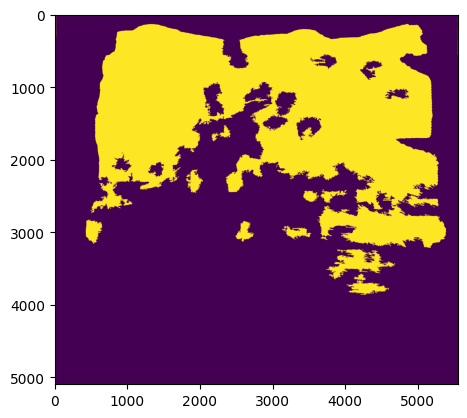

In [5]:
import matplotlib.pyplot as plt

cluster_map = np.zeros_like(segments)
for label, cluster in zip(np.unique(segments), labels):
        cluster_map[segments == label] = cluster

# Colormap ottimizzata per scala di grigi
cmap = plt.get_cmap('viridis', 2)
segmented_viz = cmap(cluster_map / (2-1))[..., :3]
segmented_viz = (segmented_viz * 255).astype(np.uint8)

plt.imshow(segmented_viz)
plt.show()


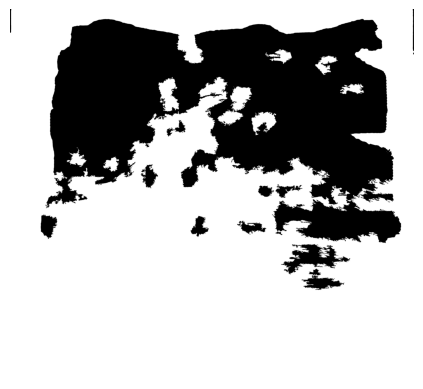

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def create_binary_cluster_mask(segments, labels, threshold=0):
    """
    Crea una maschera binaria per l'immagine basata sui cluster.

    Args:
        segments: Mappa dei superpixel
        labels: Etichette dei cluster ottenute da un algoritmo di clustering
        threshold: La soglia per determinare quale cluster è 1 (incluso), tutti gli altri sono 0

    Returns:
        binary_mask: Immagine binaria risultante (1 per un cluster e 0 per gli altri)
    """
    # Creazione della mappa dei cluster (0 o 1 in base alla soglia)
    cluster_map = np.zeros_like(segments)
    
    # Assegna ai superpixel il valore del cluster corrispondente
    for label, cluster in zip(np.unique(segments), labels):
        cluster_map[segments == label] = cluster
    
    # Creare la maschera binaria (con un threshold)
    binary_mask = (cluster_map == threshold).astype(np.uint8)

    return binary_mask

# Esegui la funzione per ottenere la maschera binaria
binary_mask = create_binary_cluster_mask(segments, labels, threshold=0)

# Visualizza l'immagine binaria
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')  # Rimuovi gli assi per una visualizzazione più pulita
plt.show()
